In [1]:
# Standard things
import math
import jax.scipy.special as jsp
import numpy as np
import jax.numpy as jnp
import jax

# FLOAT64 seems to be necessary for integral precision
jax.config.update("jax_enable_x64", True)


from utils.function1D_utils import taylor_expand_in_alpha, eval_taylor_expansion, reduce_alpha
from utils.distribution_utils import q, log_q

from utils.qcd_utils import running_coupling   
from jax.experimental.ode import odeint

# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot, hist_with_errors


### Jax setting and compilation

In [2]:
# JAX vmapping and compilation
jitted_q  = jax.jit(q)
vmapped_q = jax.vmap(jitted_q, in_axes=(0, None, None, None))

jitted_log_q  = jax.jit(log_q)
vmapped_log_q = jax.vmap(jitted_log_q, in_axes=(0, None, None, None))

# jitted_polynomial = jax.jit(polynomial)
# vmapped_polynomial = jax.vmap(jitted_polynomial, in_axes=(0, None))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


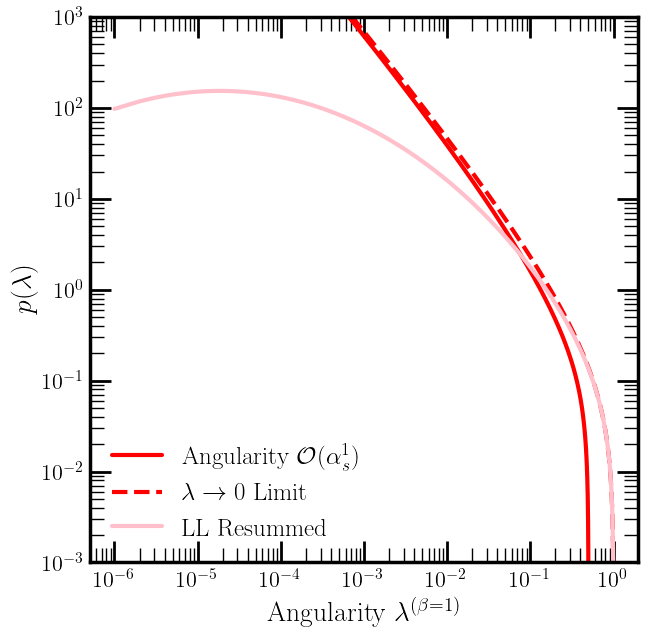

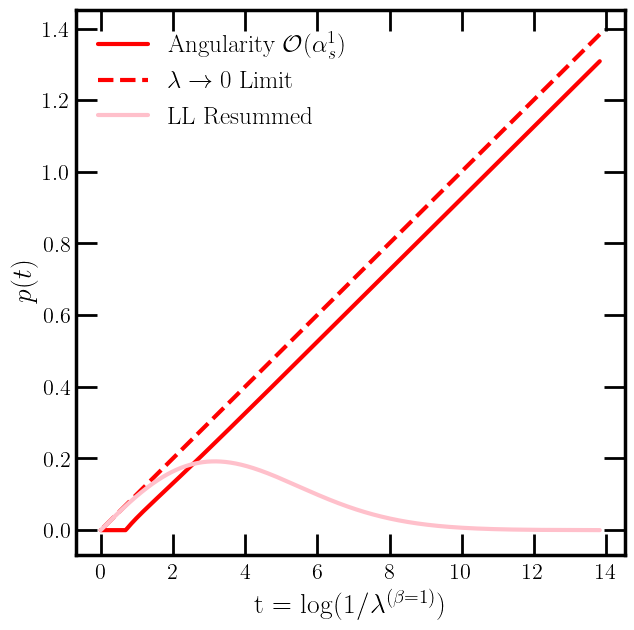

In [3]:
def angularity_full(x, alpha, param=1):
    alpha_bar = alpha * (4/3) / (2 * np.pi)
    beta = param
    theta = (x < 0.5) * (x > 0) * 1.0

    pref = (2.0 * alpha_bar) / (beta * x)
    bracket = 2.0 * jnp.log((1.0 - x) / x) + 3.0 * x - 1.5
    return pref * bracket * theta


def angualrity_0(x, alpha, param=1):
    # Soft–collinear FO
    alpha_bar = alpha * (4/3) / (2 * np.pi)
    beta = param

    pref = (2.0 * alpha_bar) / (beta * x)
    bracket = 2.0 * jnp.log(1.0 / x)
    return pref * bracket 


def angularity_resummed(x, alpha, param=1):
    alpha_bar = alpha * (4/3) / (2 * np.pi)
    beta = param

    a = 2.0 * alpha_bar / beta  

    prefactor = angualrity_0(x, alpha, beta)
    term2 = jnp.exp(-a * jnp.log(1.0 / x) ** 2)

    return prefactor * term2 




def t_from_x(x):

    return jnp.log(1/x)


def function_t_from_x(func):

    def t_func(t, alpha, params):

        x = jnp.exp(-t)
        # print(x)
        # print(func(x, alpha, params))
        return func(x, alpha, params) * x
    return t_func


t_angularity_full = function_t_from_x(angularity_full)
t_angularity_0 = function_t_from_x(angualrity_0)
t_angularity_resummed = function_t_from_x(angularity_resummed)



xs = jnp.linspace(0, 1, 1000000)
ts = t_from_x(xs)

alpha = 0.118
param = 1

fig, ax = newplot("full")
ax.plot(xs, angularity_full(xs, alpha, param), label = r"Angularity $\mathcal{O}(\alpha_s^1)$", color = "red")
ax.plot(xs, angualrity_0(xs, alpha, param), label = r"$\lambda \to 0$ Limit", color = "red", ls = "--")
ax.plot(xs, angularity_resummed(xs, alpha, param), label = r"LL Resummed", color = "pink")
ax.legend()
ax.set_xlabel(r"Angularity $\lambda^{(\beta = 1)}$")
ax.set_ylabel(r"$p(\lambda)$")

plt.ylim(1e-3, 1e3)

plt.xscale("log")
plt.yscale("log")

plt.savefig("plots/angularity_full.pdf")



fig, ax = newplot("full")


ax.plot(ts, t_angularity_full(ts, alpha, param), label = r"Angularity $\mathcal{O}(\alpha_s^1)$", color = "red")
ax.plot(ts, t_angularity_0(ts, alpha, param), label = r"$\lambda \to 0$ Limit", color = "red", ls = "--")
ax.plot(ts, t_angularity_resummed(ts, alpha, param), label = r"LL Resummed", color = "pink")
ax.legend()
ax.set_xlabel(r"t =  $\log(1/\lambda^{(\beta = 1)})$")
ax.set_ylabel(r"$p(t)$")
# plt.ylim(1e-3, 1e3)

# plt.axvline(jnp.log(2), color = "grey", ls = "--", lw = 2)

plt.savefig("plots/angularity_full_t.pdf")



In [4]:
def Li2(z):
    return (jnp.pi ** 2) / 6.0 - jsp.spence(1.0 - z)

def p_FO_t(t, alpha, beta=1):
    alpha_bar = alpha * (4/3) / (2 * np.pi)
    a = 2.0 * alpha_bar / beta  

    theta = (t > jnp.log(2.0)) * 1.0
    bracket = (
        2.0 * t
        + 2.0 * jnp.log(1.0 - jnp.exp(-t))
        + 3.0 * jnp.exp(-t)
        - 1.5
    )
    return a * bracket * theta

def q_full_t(t, alpha, beta=1):
    alpha_bar = alpha * (4/3) / (2 * np.pi)
    a = 2.0 * alpha_bar / beta

    theta = (t > jnp.log(2.0)) * 1.0

    # FO bracket
    bracket = (
        2.0 * t
        + 2.0 * jnp.log(1.0 - jnp.exp(-t))
        + 3.0 * jnp.exp(-t)
        - 1.5
    )

    # Integral in the exponent 
    li_piece = 2.0 * (Li2(jnp.exp(-t)) - Li2(0.5))
    integral_bracket = (
        t**2 - (jnp.log(2.0))**2
        + li_piece
        - 3.0 * (jnp.exp(-t) - 0.5)
        - 1.5 * (t - jnp.log(2.0))
    )

    return a * bracket * jnp.exp(-a * integral_bracket) * theta

def q_soft_t(t, alpha, beta=1):
    alpha_bar = alpha * (4/3) / (2 * np.pi)
    a = 2.0 * alpha_bar / beta 
    return a * (2.0 * t) * jnp.exp(-a * t**2)




In [5]:
# Variations

eps = 1e-12
def g_FO(t, alpha, beta=1, rstar = 0, ranalytic = 0):
    # baseline g from FO

    return np.nan_to_num(p_FO_t(t, alpha, beta)  + rstar), np.nan_to_num(ranalytic)

    return -jnp.log(p_FO_t(t, alpha, beta) + eps + rstar) + ranalytic



def build_q_from_g(g_func):

    def q_t(ts, alpha, beta=1, *g_args, **g_kwargs):
        # ts: array of t values (e.g. linspace)
        g_vals = g_func(ts, alpha, beta, *g_args, **g_kwargs)
        f_vals = g_vals[0] * jnp.exp(-g_vals[1])


        dt = ts[1] - ts[0]
        # integral_0^t f = cumulative sum
        F_vals = jnp.cumsum(f_vals) * dt

        return f_vals * jnp.exp(-F_vals)
    return q_t


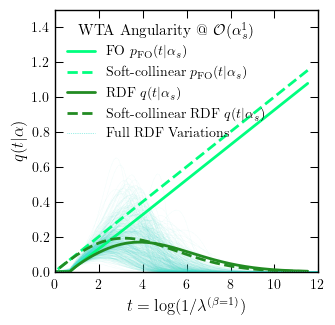

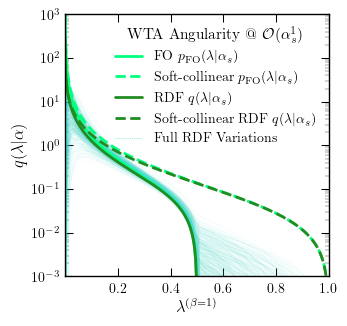

In [22]:
xs = jnp.logspace(-5, 0, 2000)  # λ ∈ [1e-5, 1]
ts = t_from_x(xs)

alpha = 0.118
param = 1


def q_full_x(x, alpha, beta=1):
    t = jnp.log(1.0 / x)
    return q_full_t(t, alpha, beta) / x  # convert q(t) to p(x)

def q_soft_x(x, alpha, beta=1):
    t = jnp.log(1.0 / x)
    return q_soft_t(t, alpha, beta) / x



# t-space 

fig, ax = newplot("column")


t_linspace = np.linspace(0, 16, 500)
for j in range(500):
    
        g1 =  1 * (np.random.normal(0, 1, size = 5)) *1
        g2 =  1 * (np.random.normal(0, 1, size = 5)) * 1
        g1[0] = 0
        g2[0] = 0
        g2[-1] = np.abs(g2[-1])
        theta = np.random.rand() * np.log(2)

        r1 = np.zeros_like(t_linspace)
        r2 = np.zeros_like(t_linspace)
        for i in range(1, 5):
             r1 += alpha**2 * g1[i] * (t_linspace-theta)**i/math.factorial(i) * (t_linspace > theta) 
             r2 += alpha**1 * g2[i] * (t_linspace-theta)**i/math.factorial(i) * (t_linspace > theta) 

        r1 = np.abs(r1)

        new_q = build_q_from_g(g_FO)

        ax.plot(t_linspace, new_q(t_linspace, alpha, beta = 1, rstar = r1, ranalytic = r2), lw = 0.25, alpha = 0.25, color = "turquoise", ls = ":")


ax.plot(ts, t_angularity_full(ts, alpha, param), label=r"FO $p_{\rm FO}(t|\alpha_s)$", color="springgreen", lw = 2)
ax.plot(ts, t_angularity_0(ts, alpha, param), label=r"Soft-collinear $p_{\rm FO}(t|\alpha_s)$", color="springgreen", ls="--", lw = 2)
ax.plot(ts, q_full_t(ts, alpha, param),label=r"RDF $q(t|\alpha_s)$", color="forestgreen", lw = 2)
ax.plot(ts, q_soft_t(ts, alpha, param),  label=r"Soft-collinear RDF $q(t|\alpha_s)$", color="forestgreen", ls="--", lw = 2)

label = "Full RDF Variations"
ax.plot(t_linspace, -new_q(t_linspace, alpha, beta = 1, rstar = r1, ranalytic = r2), lw = 0.5, color = "turquoise", ls = ":", label = label)


ax.legend(title = r"WTA Angularity @ $\mathcal{O}(\alpha_s^1)$")
ax.set_xlabel(r"$t = \log(1/\lambda^{(\beta=1)})$")
ax.set_ylabel(r"$q(t|\alpha)$")

plt.ylim(0, 1.5)
plt.xlim(0, 12)



# ax.axvline(jnp.log(2), color="grey", ls="--", lw=2)
plt.savefig("plots/angularity_full_t.pdf", bbox_inches = "tight")






# ##### x space #####
fig, ax = newplot("column")


x_linspace = jnp.exp(-t_linspace)
for j in range(500):
    
        g1 =  1 * (np.random.normal(0, 1, size = 5)) / 2
        g2 =  1 * (np.random.normal(0, 1, size = 5)) * 1
        # g1[0] = 0
        # g2[0] = 0
        g2[-1] = np.abs(g2[-1])
        theta = np.random.rand() * np.log(2)
        # print(theta)

        r1 = np.zeros_like(t_linspace)
        r2 = np.zeros_like(t_linspace)
        for i in range(1, 5):
             r1 += alpha**2 * g1[i] * (t_linspace-theta)**i/math.factorial(i) * (t_linspace  > theta) 
             r2 += alpha**1 * g2[i] * (t_linspace-theta)**i/math.factorial(i) * (t_linspace  > theta) 

        r1 = np.abs(r1)

        new_q = build_q_from_g(g_FO)
        ax.plot(x_linspace, new_q(t_linspace, alpha, beta = 1, rstar = r1, ranalytic = r2) / x_linspace, lw = 0.25, alpha = 0.25, color = "turquoise", ls = ":")


ax.plot(xs, angularity_full(xs, alpha, param),label=r"FO $p_{\rm FO}(\lambda|\alpha_s)$", color="springgreen", lw = 2)
ax.plot(xs, angualrity_0(xs, alpha, param),label=r"Soft-collinear $p_{\rm FO}(\lambda|\alpha_s)$", color="springgreen", ls="--", lw = 2)
ax.plot(xs, q_full_x(xs, alpha, param),label=r"RDF $q(\lambda|\alpha_s)$", color="forestgreen", lw = 2)
ax.plot(xs, q_soft_x(xs, alpha, param),label=r"Soft-collinear RDF $q(\lambda|\alpha_s)$", color="forestgreen", ls="--", lw = 2)


# Dummy legend
label = "Full RDF Variations"
ax.plot(x_linspace, -new_q(t_linspace, alpha, beta = 1, rstar = r1, ranalytic = r2) / x_linspace, alpha =1, color = "turquoise", label = label, ls = ":", lw = 0.5)


ax.legend(title = r"WTA Angularity @ $\mathcal{O}(\alpha_s^1)$")
ax.set_xlabel(r"$\lambda^{(\beta=1)}$")
ax.set_ylabel(r"$q(\lambda|\alpha)$")


# ax.set_xscale("log")   
ax.set_yscale("log")
plt.ylim(1e-3, 1e3)
plt.xlim(np.exp(-12), 1)


plt.savefig("plots/angularity_full_x.pdf", bbox_inches="tight")

